In [1]:
#导入必要工具包
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import mne
#import mnelab
import matplotlib.dates as mdate
from mne.preprocessing import ICA


Extracting EDF parameters from D:\JQ_YJS\过山车实验数据\sub01\t1_rest1_convert.cdt.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116799  =      0.000 ...   114.062 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


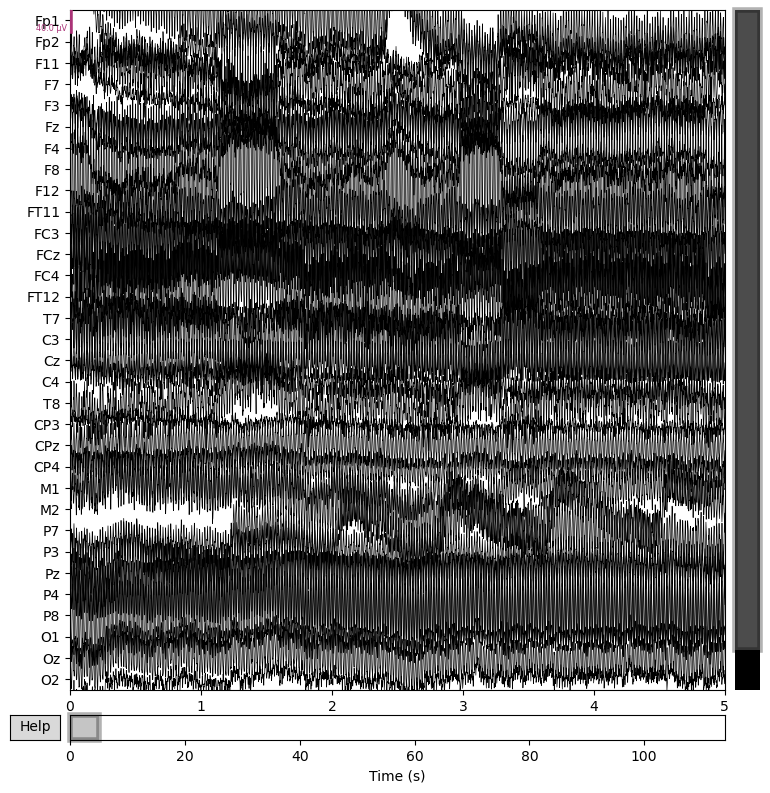

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F11, F7, F3, Fz, F4, F8, F12, FT11, FC3, FCz, FC4, ...
 chs: 34 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2022-08-20 10:32:36 UTC
 nchan: 34
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 3 items (dict)
>
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6759 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=1, n_times=116800
    Range : 0 ... 116799 =      0.000 ...   114.062 secs
Ready.
Added the following bipolar channels:
M1-M2
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


KeyboardInterrupt: 

In [2]:
#对每个rest1，rest2，task数据进行预处理
for sub in range(1,16):
    if sub<=9:
            for t in range(1,7):
                for r in range(1,4):
                    if r==1 or r==2:
                        datapath=(r'D:\JQ_YJS\过山车实验数据\sub0{}\t{}_rest{}_convert.cdt.edf'.format(sub,t,r))
                        raw=mne.io.read_raw_edf(datapath,preload=True,exclude=('EGG','ECG'))#读取数据
                        #可视化原始数据
                        #绘制原始数据波形图
                        #raw.plot(duration=5,n_channels=32,clipping=None)
                        #绘制原始数据功率谱图
                        #raw.plot_psd(average=True)
                        #截止时间
                        raw.load_data()
                        raw.pick_types(eeg=True, stim=False).plot(duration=5,n_channels=32,clipping=None)
                        
                        chan_types_dict={raw.info.ch_names[i]:'eeg' for i in range(32)} #设定导联类型为eeg和eog
                        chan_types_dict={'VEOG':'eog','HEOG':'eog'} #设定导联类型为eeg和eog
                        raw.set_channel_types(chan_types_dict) #设定导联类型为eeg和eog
                        raw.rename_channels(mapping={'F11':'F9','F12':'F10','FT11':'FT9','FT12':'FT10'})#重命名导联名称
                        raw.info.set_montage('standard_1020')#脑区电极定位
                        montage=mne.channels.make_standard_montage('standard_1020')
                        raw.set_montage(montage,on_missing='raise',verbose=None)
                        #滤波
                        raw=raw.notch_filter(freqs=(50)) # 陷波滤波
                        raw=raw.filter(l_freq=0.5,h_freq=45) # 高低通滤波
                        #raw.plot_psd(average=True)
                        #重参考
                        raw_bip_ref=mne.set_bipolar_reference(raw,anode=['M1'],cathode=['M2'])
                        #ICA,独立成分分析
                        ica=ICA(n_components=32,max_iter='auto')#n_components=int根据实际需求写
                        raw_for_ica=raw.copy().filter(l_freq=1,h_freq=None)
                        ica.fit(raw_for_ica)
                        #ica.plot_sources(raw_for_ica) # 绘制各成分的时序信号图
                        #ica.plot_components() # 绘制各成分地形图
                        #ICA自动去眼电
                        ica.exclude=[]
                        eog_indices,eog_scores=ica.find_bads_eog(raw)
                        ica.exclude=eog_indices
                        ica.apply(raw)
                        #raw.plot(duration=5, n_channels=32, clipping=None)
                        raw = raw.resample(sfreq=200)
                        raw.set_eeg_reference(ref_channels='average')
                        import pathlib
                        raw.save(r'D:\JQ_YJS\过山车实验数据fif\sub0{}\t{}rest{}.fif'.format(sub,t,r),overwrite=True)
                        #raw.save(pathlib.Path('rollercoaster2')/'sub0{}'.format(sub)/'t{}rest{}.fif'.format(t,r),overwrite=True)
                    else:
                        datapath=(r'D:\JQ_YJS\过山车实验数据\sub0{}\t{}_task_convert.cdt.edf'.format(sub,t))
                        raw=mne.io.read_raw_edf(datapath,preload=True,exclude=('EGG','ECG'))#读取数据
                        #可视化原始数据
                        #绘制原始数据波形图
                        #raw.plot(duration=5,n_channels=32,clipping=None)
                        #绘制原始数据功率谱图
                        #raw.plot_psd(average=True)
                        #截止时间
                        raw.load_data()
                        raw.pick_types(eeg=True, stim=False).plot(duration=5,n_channels=32,clipping=None)
                        chan_types_dict={raw.info.ch_names[i]:'eeg' for i in range(32)} #设定导联类型为eeg和eog
                        chan_types_dict={'VEOG':'eog','HEOG':'eog'} #设定导联类型为eeg和eog
                        raw.set_channel_types(chan_types_dict) #设定导联类型为eeg和eog
                        raw.rename_channels(mapping={'F11':'F9','F12':'F10','FT11':'FT9','FT12':'FT10'})#重命名导联名称
                        raw.info.set_montage('standard_1020')#脑区电极定位
                        montage=mne.channels.make_standard_montage('standard_1020')
                        raw.set_montage(montage,on_missing='raise',verbose=None)
                        #滤波
                        raw=raw.notch_filter(freqs=(50)) # 陷波滤波
                        raw=raw.filter(l_freq=0.5,h_freq=45) # 高低通滤波
                        #raw.plot_psd(average=True)
                        #重参考
                        raw_bip_ref=mne.set_bipolar_reference(raw,anode=['M1'],cathode=['M2'])
                        #ICA,独立成分分析
                        ica=ICA(n_components=32,max_iter='auto')#n_components=int根据实际需求写
                        raw_for_ica=raw.copy().filter(l_freq=1,h_freq=None)
                        ica.fit(raw_for_ica)
                        #ica.plot_sources(raw_for_ica) # 绘制各成分的时序信号图
                        #ica.plot_components() # 绘制各成分地形图
                        #ICA自动去眼电
                        ica.exclude=[]
                        eog_indices,eog_scores=ica.find_bads_eog(raw)
                        ica.exclude=eog_indices
                        ica.apply(raw)
                        #raw.plot(duration=5, n_channels=32, clipping=None)
                        raw = raw.resample(sfreq=200)
                        raw.set_eeg_reference(ref_channels='average')
                        import pathlib
                        raw.save(r'D:\JQ_YJS\过山车实验数据fif\sub0{}\t{}task.fif'.format(sub,t),overwrite=True)
                        #raw.save(pathlib.Path('rollercoaster2')/'sub0{}'.format(sub)/'t{}task.fif'.format(t),overwrite=True)
    else:
        for t in range(1,7):
            for r in range(1,4):
                if r==1 or r==2:
                    datapath=(r'D:\JQ_YJS\过山车实验数据\sub{}\t{}_rest{}_convert.cdt.edf'.format(sub,t,r))
                    raw=mne.io.read_raw_edf(datapath,preload=True,exclude=('EGG','ECG'))#读取数据
                    #可视化原始数据
                    #绘制原始数据波形图
                    #raw.plot(duration=5,n_channels=32,clipping=None)
                    #绘制原始数据功率谱图
                    #raw.plot_psd(average=True)
                    #截止时间
                    raw.load_data()
                    raw.pick_types(eeg=True, stim=False).plot(duration=5,n_channels=32,clipping=None)
                    chan_types_dict={raw.info.ch_names[i]:'eeg' for i in range(32)} #设定导联类型为eeg和eog
                    chan_types_dict={'VEOG':'eog','HEOG':'eog'} #设定导联类型为eeg和eog
                    raw.set_channel_types(chan_types_dict) #设定导联类型为eeg和eog
                    raw.rename_channels(mapping={'F11':'F9','F12':'F10','FT11':'FT9','FT12':'FT10'})#重命名导联名称
                    raw.info.set_montage('standard_1020')#脑区电极定位
                    montage=mne.channels.make_standard_montage('standard_1020')
                    raw.set_montage(montage,on_missing='raise',verbose=None)
                    #滤波
                    raw=raw.notch_filter(freqs=(50)) # 陷波滤波
                    raw=raw.filter(l_freq=0.5,h_freq=45) # 高低通滤波
                    #raw.plot_psd(average=True)
                    #重参考
                    raw_bip_ref=mne.set_bipolar_reference(raw,anode=['M1'],cathode=['M2'])
                    #ICA,独立成分分析
                    ica=ICA(n_components=32,max_iter='auto')#n_components=int根据实际需求写
                    raw_for_ica=raw.copy().filter(l_freq=1,h_freq=None)
                    ica.fit(raw_for_ica)
                    #ica.plot_sources(raw_for_ica) # 绘制各成分的时序信号图
                    #ica.plot_components() # 绘制各成分地形图
                    #ICA自动去眼电
                    ica.exclude=[]
                    eog_indices,eog_scores=ica.find_bads_eog(raw)
                    ica.exclude=eog_indices
                    ica.apply(raw)
                    #raw.plot(duration=5, n_channels=32, clipping=None)
                    raw = raw.resample(sfreq=200)
                    raw.set_eeg_reference(ref_channels='average')
                    import pathlib
                    raw.save(r'D:\JQ_YJS\过山车实验数据fif\sub{}\t{}rest{}.fif'.format(sub,t,r),overwrite=True)
                    #raw.save(pathlib.Path('rollercoaster2')/'sub{}'.format(sub)/'t{}rest{}.fif'.format(t,r),overwrite=True)
                else:
                    datapath=(r'D:\JQ_YJS\过山车实验数据\sub{}\t{}_task_convert.cdt.edf'.format(sub,t))
                    raw=mne.io.read_raw_edf(datapath,preload=True,exclude=('EGG','ECG'))#读取数据
                    #可视化原始数据
                    #绘制原始数据波形图
                    #raw.plot(duration=5,n_channels=32,clipping=None)
                    #绘制原始数据功率谱图
                    #raw.plot_psd(average=True)
                    #截止时间
                    raw.load_data()
                    raw.pick_types(eeg=True, stim=False).plot(duration=5,n_channels=32,clipping=None)
                    chan_types_dict={raw.info.ch_names[i]:'eeg' for i in range(32)} #设定导联类型为eeg和eog
                    chan_types_dict={'VEOG':'eog','HEOG':'eog'} #设定导联类型为eeg和eog
                    raw.set_channel_types(chan_types_dict) #设定导联类型为eeg和eog
                    raw.rename_channels(mapping={'F11':'F9','F12':'F10','FT11':'FT9','FT12':'FT10'})#重命名导联名称
                    raw.info.set_montage('standard_1020')#脑区电极定位
                    montage=mne.channels.make_standard_montage('standard_1020')
                    raw.set_montage(montage,on_missing='raise',verbose=None)
                    #滤波
                    raw=raw.notch_filter(freqs=(50)) # 陷波滤波
                    raw=raw.filter(l_freq=0.5,h_freq=45) # 高低通滤波
                    #raw.plot_psd(average=True)
                    #重参考
                    raw_bip_ref=mne.set_bipolar_reference(raw,anode=['M1'],cathode=['M2'])
                    #ICA,独立成分分析
                    ica=ICA(n_components=32,max_iter='auto')#n_components=int根据实际需求写
                    raw_for_ica=raw.copy().filter(l_freq=1,h_freq=None)
                    ica.fit(raw_for_ica)
                    #ica.plot_sources(raw_for_ica) # 绘制各成分的时序信号图
                    #ica.plot_components() # 绘制各成分地形图
                    #ICA自动去眼电
                    ica.exclude=[]
                    eog_indices,eog_scores=ica.find_bads_eog(raw)
                    ica.exclude=eog_indices
                    ica.apply(raw)
                    #raw.plot(duration=5, n_channels=32, clipping=None)
                    raw = raw.resample(sfreq=200)
                    raw.set_eeg_reference(ref_channels='average')
                    import pathlib
                    raw.save(r'D:\JQ_YJS\过山车实验数据fif\sub{}\t{}task.fif'.format(sub,t),overwrite=True)
                    #raw.save(pathlib.Path('rollercoaster2')/'sub{}'.format(sub)/'t{}task.fif'.format(t),overwrite=True)
                        

In [ ]:
#将所有的rest1合并到combined_rest1，将所有的rest2合并到combined_rest2，将所有的task合并到combined_rest3
nb_rest1=[]
nb_rest2=[]
nb_task=[]
for sub in range(1,16):
    for t in range(1,7):
        for r in range(1,4):
          if r==1:
             datapath1 = r'D:\JQ_YJS\过山车实验数据fif\sub{}\t{}rest{}.fif'.format(sub,t,r)
             data1 = mne.io.read_raw_fif(datapath1,preload=True)
             nb_rest1.append(data1)
          else:
              if r==2:
                  datapath2 = r'D:\JQ_YJS\过山车实验数据fif\sub{}\t{}rest{}.fif'.format(sub,t,r)
                  data2 = mne.io.read_raw_fif(datapath2,preload=True)
                  nb_rest2.append(data2)   
              else:
                  datapath3 = r'D:\JQ_YJS\过山车实验数据fif\sub{}\t{}task.fif'.format(sub,t)
                  data3 = mne.io.read_raw_fif(datapath3,preload=True)
                  nb_task.append(data3)


combined_rest2 = mne.concatenate_raws(nb_rest2)
# 保存合并后的 Raw 对象为一个 .fif 文件
combined_save_path = r'D:\JQ_YJS\过山车数据class\combined_rest2.fif'
combined_rest2.save(combined_save_path, overwrite=True)

combined_rest1 = mne.concatenate_raws(nb_rest1)
# 保存合并后的 Raw 对象为一个 .fif 文件
combined_save_path = r'D:\JQ_YJS\过山车数据class\combined_rest1.fif'
combined_rest2.save(combined_save_path, overwrite=True)

combined_rest3 = mne.concatenate_raws(nb_task)
# 保存合并后的 Raw 对象为一个 .fif 文件
combined_save_path = r'D:\JQ_YJS\过山车数据class\combined_rest3.fif'
combined_rest2.save(combined_save_path, overwrite=True)

'''nb_rest_array1 = np.array(nb_rest1,dtype=object)
nb_rest_array2 = np.array(nb_rest2,dtype=object)
nb_rest_array3 = np.array(nb_task,dtype=object)
np.save(r'D:\JQ_YJS\过山车数据class\rest1_class.npy', nb_rest_array1)
np.save(r'D:\JQ_YJS\过山车数据class\rest2_class.npy', nb_rest_array2)
np.save(r'D:\JQ_YJS\过山车数据class\task_class.npy', nb_rest_array3)'''


In [1]:
#将combined_rest1分割成epochs，z-scores

from sklearn.preprocessing import StandardScaler 
datapath=r'D:\JQ_YJS\过山车数据class\combined_rest1.fif'
raw=mne.io.read_raw_fif(datapath, preload=True)
raw=raw.pick(picks= 'all',exclude=['VEOG' ,'HEOG','M1' ,'M2'])
epochs=mne.make_fixed_length_epochs(raw, duration=1, preload=True, reject_by_annotation=True)
epochs.drop_bad(reject=dict(eeg=2e-3))
print(f"啦啦啦啦Number of epochs: {len(epochs)}")
a=list(range(1,10506))
for epoch,i in zip(epochs,a):
              normal_epoch=StandardScaler().fit_transform(epoch)
              np.save(r'D:\JQ_YJS\fen_duan_hou\rest1_epochs\_{}epoch.npy'.format(i),normal_epoch)




NameError: name 'mne' is not defined

In [ ]:
#将combined_rest分割成epochs，z-scores
from sklearn.preprocessing import StandardScaler 
datapath=r'D:\JQ_YJS\过山车数据class\combined_rest2.fif'
raw=mne.io.read_raw_fif(datapath, preload=True)
raw=raw.pick(picks= 'all',exclude=['VEOG' ,'HEOG','M1' ,'M2'])
epochs=mne.make_fixed_length_epochs(raw, duration=1, preload=True, reject_by_annotation=True)
epochs.drop_bad(reject=dict(eeg=2e-3))
print(f"啦啦啦啦Number of epochs: {len(epochs)}")
a=list(range(1,10506))
for epoch,i in zip(epochs,a):
              normal_epoch=StandardScaler().fit_transform(epoch)
              np.save(r'D:\JQ_YJS\fen_duan_hou\rest2_epochs\_{}epoch.npy'.format(i),normal_epoch)


In [ ]:
#将combined_rest3分割成epochs，z-scores
from sklearn.preprocessing import StandardScaler 
datapath=r'D:\JQ_YJS\过山车数据class\combined_rest3.fif'
raw=mne.io.read_raw_fif(datapath, preload=True)
raw=raw.pick(picks= 'all',exclude=['VEOG' ,'HEOG','M1' ,'M2'])
epochs=mne.make_fixed_length_epochs(raw, duration=1, preload=True, reject_by_annotation=True)
epochs.drop_bad(reject=dict(eeg=2e-3))
print(f"啦啦啦啦Number of epochs: {len(epochs)}")
a=list(range(1,10506))
for epoch,i in zip(epochs,a):
              normal_epoch=StandardScaler().fit_transform(epoch)
              np.save(r'D:\JQ_YJS\fen_duan_hou\task_epochs\_{}epoch.npy'.format(i),normal_epoch)

In [1]:
#合并epochs为一个
nb_rest = []
for e in range(1,10506):
    datapath1 = r'D:\JQ_YJS\过山车实验数据epochs（3）\rest1_epochs\_{}epoch.npy'.format(e)
    data1 = np.load(datapath1)
    # 将数据添加到 nb_rest 列表中
    nb_rest.append(data1)
    # 将 nb_rest 列表转换为 NumPy 数组
nb_rest_array = np.array(nb_rest)
# 保存该 subject 的所有 epoch 数据
np.save(r'D:\JQ_YJS\过山车实验数据epochs转一个class（4）\rest1_class.npy', nb_rest_array)

NameError: name 'np' is not defined

In [ ]:
#合并epochs为一个
nb_rest = []
for e in range(1,10506):
    datapath1 = r'D:\JQ_YJS\过山车实验数据epochs（3）\rest2_epochs\_{}epoch.npy'.format(e)
    data1 = np.load(datapath1)
    # 将数据添加到 nb_rest 列表中
    nb_rest.append(data1)
    # 将 nb_rest 列表转换为 NumPy 数组
nb_rest_array = np.array(nb_rest)
# 保存该 subject 的所有 epoch 数据
np.save(r'D:\JQ_YJS\过山车实验数据epochs转一个class（4）\rest2_class.npy', nb_rest_array)
print(nb_rest_array.shape)